## 差分进化

In [18]:
import numpy as np
import random
from tqdm import tqdm # 进度条显示

### 目标函数

求函数的最小值
$z=f(x,y)=(x^2+y^2)-e^{-(x^2+y^2)},\left(-10\leq x,y\leq10\right)$

<img src="../imgs/3d_function.png">

In [19]:
# 适应度函数/目标函数
def function(x,y): # x,y两个变量，也即D=2
    return (x**2 + y**2) - np.exp(-(x**2 + y**2))
# 求适应度
def fitness(x):
    result=np.empty(x.shape[1]) # 记录种群中个体的适应度
    # 计算每个个体的适应度
    for i in range(0,x.shape[1]):
        result[i]=function(x[0,i],x[1,i])
    return result

### 差分变异
$v_{i,G+1}=x_{r_1,G}+F\cdot(x_{r_2,G}-x_{r_3,G})$

差分的优化：
$v_{i,G+1}=x_{best,G}+F\cdot(x_{r_{1},G}+x_{r_{2},G}-x_{r_{3},G}-x_{r_{4},G})$

其中$v_i$是突变的结果
i=1,2,3,...,NP
$r_1、r_2、r_3$是随机选择的三个个体的索引
F是突变因子，范围在[0,2]，控制差分的权重

In [20]:
# 差分变异，发生在不同的个体之间
def variation(x,F):
    # 初始化变异个体
    v = np.zeros(x.shape)
    for i in range(0,x.shape[1]):
        # 表示的是在0-NP范围内，随机生成3个整数，作为索引，且保证3个索引不与当前的循环次数i重复（通过这种方式来确保至少有一个个体是变异了的）
        randoms=random.sample(range(0,x.shape[1]),3)# 表示的是在0-x.shape[1]范围内，随机生成3个整数，作为索引
        while randoms[0]==i or randoms[1]==i or randoms[2]==i :
            randoms=random.sample(range(0,x.shape[1]),3)
        # 计算变异的个体
        v[:,i]=x[:,randoms[0]]+F*(x[:,randoms[1]]-x[:,randoms[2]])
    return v

# 变异的优化
def variation_optimize(x,F):
    # 初始化变异个体
    v = np.zeros(x.shape)
    for i in range(0,x.shape[1]):

        # 表示的是在0-NP范围内，随机生成5个整数，作为索引，且保证5个索引不与当前的循环次数i重复（通过这种方式来确保至少有一个个体是变异了的）
        randoms=random.sample(range(0,x.shape[1]),5)# 表示的是在0-x.shape[1]范围内，随机生成5个整数，作为索引
        while randoms[0]==i or randoms[1]==i or randoms[2]==i or randoms[3]==i or randoms[4]==i:
            randoms=random.sample(range(0,x.shape[1]),5)
        # 计算变异的个体
        v[:,i]=x[:,randoms[0]]+F*(x[:,randoms[1]]+x[:,randoms[2]]-x[:,randoms[3]]-x[:,randoms[4]])
    return v

### 交叉
$u_{i,G+1}=(u_{1i,G+1},u_{2i,G+1},\ldots,u_{Di,G+1})$

对于$u_{i,G+1}$

<img src="../imgs/crossover.png" style="zoom:20%;">

CR是交叉因子
$rnbr(i)$是一个范围在[1,2,...,D]的随机数

In [21]:
# 交叉
def cross(x,v,CR):
    u = np.zeros((D, NP))
    rate=np.random.rand()
    for i in range(0,x.shape[0]):
        if rate<=CR or i==rate:
           u[i,:]=v[i,:]
        else:
           u[i,:]=x[i,:]
    return u


### 边界处理（防止溢出）

In [22]:
# 边界处理
def boundary_process(x,left,right):
    for i in range(0,x.shape[0]):
        for j in range(0,x.shape[1]):
            if x[i][j] < left or x[i][j]>right:
                x[i][j]= random.random()*(right - left) + left
    return x

### 参数初始化

In [23]:
NP = 20  # 个体数目
D = 2  # 目标函数中变量的个数
G = 500  # 最大迭代数
CR = 0.1  # 交叉算子
Threshold = 1e-6  # 阈值
F=0.4 # 变异算子
Left = -10 # 左边界
Right = 10 # 右边界


### 算法的执行

In [24]:
x = np.random.rand(D, NP) * (Right - Left) + Left   # 在[Left,Right]之间产生随机数

# 记录进化迭代的过程
number_generations=G
per_generation_optimal_value=np.zeros(G)

per_generation_D_NP=np.zeros((G,D,NP))
per_generation_fitness=np.zeros((G,NP))

x_fitness=fitness(x)

with tqdm(total=G, desc="DE") as pbar:
    for i in range(0,G):
        #v=variation(x,F) # 变异
        v=variation_optimize(x,F) # 变异的优化
        c=cross(x,v,CR) # 交叉
        
        c=boundary_process(c,Left,Right) # 若超出边界则重新生成
        
        c_fitness=fitness(c) # 对新的试验种群求适应度
        for m in range(0,x.shape[1]):
            if c_fitness[m]<x_fitness[m]: # 贪婪地选择当前最优个体
                x[:,m]=c[:,m]
                x_fitness[m]=c_fitness[m]
        index=np.argmin(x_fitness) # 记录最优个体索引
        per_generation_optimal_value[i]=x_fitness[index] # 记录最优适应度
         # 动态更新进度条信息
        pbar.set_postfix({
            "当前迭代次数": i + 1, 
            "最优个体索引": index, 
            "目标函数最小值": x_fitness[index]
        })
        # 更新进度条
        pbar.update(1)
        per_generation_D_NP[i]=x
        per_generation_fitness[i]=x_fitness   

DE: 100%|██████████| 500/500 [00:00<00:00, 1162.65it/s, 当前迭代次数=500, 最优个体索引=0, 目标函数最小值=-1]    


### 进化曲线

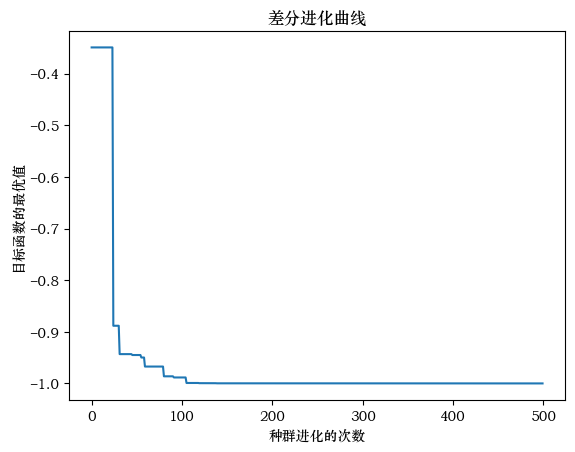

In [25]:

import matplotlib.pyplot as plt
# 设置可显示中文宋体
plt.rcParams['font.family'] = 'STZhongsong'
# 生成 x 轴数据：0 到 G，间隔为 1
x = np.arange(0, number_generations, 1)

# 生成 y 轴数据：每次迭代的最优值
y = per_generation_optimal_value

# 绘制折线图
plt.plot(x, y)

# 设置标题和坐标轴标签
plt.title("差分进化曲线")
plt.xlabel("种群进化的次数")
plt.ylabel("目标函数的最优值")

# 显示图形
plt.show()


### 保存图片

In [26]:
path_imgs="C://Users//sc_zh//Desktop//演化计算//imgs//"
path_video="C://Users//sc_zh//Desktop//演化计算//video//"
import numpy as np
import matplotlib.pyplot as plt

# 定义二元函数
def f(x, y):
    return (x**2 + y**2) - np.exp(-(x**2 + y**2))

for i in range(0,150):
    # 创建网格
    x = np.linspace(-10, 10, 1000)
    y = np.linspace(-10, 10, 1000)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    
    # 创建图形
    
    plt.contour(X, Y, Z, levels=40, cmap='viridis')  # 使用 contourf 可创建填充的等高线
    
    # 添加颜色条
    plt.colorbar()
    
    # 设置图形标题和标签
    plt.title("3D plot with Discrete Points")
    plt.xlabel('X')
    plt.ylabel('Y')
     # 标注全局最小值点
    for j in range(0,NP): 
        plt.scatter(per_generation_D_NP[i,0,j], per_generation_D_NP[i,1,j], color='r', s=50, zorder=5)
    # 保存图像到指定目录 图片格式为 "index.jpg"
    output_path = path_imgs+ f'//de_{i+1}.jpg'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    # 显示图形
    #plt.show()
    plt.close()




### 合成视频

In [29]:
import imageio

# 转换函数
def convert_pictures_to_video(input_path, output_path, videofilename, size=800):
    '''
        >>>#param input_path: 输入路径
        >>>#param output_path: 输出路径
        >>>#size，图片的数量 默认为800张
        >>>#return: 无返回值
    '''
    # 创建一个空列表，用于存储所有图片的文件名
    image_files = []
    # 遍历数组的第一个维度，生成图片文件名并添加到列表中
    for i in range(1, size + 1):
        image_file = input_path + f"//de_{i}.jpg"
        image_files.append(image_file)
    # 使用imageio库将所有图片合成为一个视频文件
    with imageio.get_writer(output_path + videofilename, mode='I') as writer:
        for filename in image_files:
            image = imageio.imread(filename)
            writer.append_data(image)
# 函数调用，合成mp4格式的视频
convert_pictures_to_video(path_imgs,path_video,"de_contour.mp4",size=150)

C:\Users\sc_zh\AppData\Local\Temp\ipykernel_25032\1588746156.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1686, 1350) to (1696, 1360) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
